# LSTM

LSTM es un modelo de redes neuronales que permite retener y recordar información relevante de secuencias largas.

In [176]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas import DataFrame
import joblib
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import GridSearchCV


In [177]:
# Semilla
np.random.seed(42)
tf.random.set_seed(42)
# Creo la importante es esa, la que usa kera
random.seed(42)

# Carga de datos

In [178]:
inPath = "../../1 Preprocesado"

# Ficheros de datos
polen = pd.read_csv(f"{inPath}/polen/gramineasGETA.csv")
tiempo = pd.read_csv(f"{inPath}/tiempo/Getafe.csv")

# Unimos los datos
datos = pd.merge(polen, tiempo, on='fecha')

In [179]:
# Constantes
ANTICIPACION = 1 # Número de días de anticipación con los que se predice
NUM_DIAS = 15   # Número de días en base a los que se predice
MODEL_FILE_NAME = f'LSTM Bir{NUM_DIAS}_{ANTICIPACION}.pkl' #Archivo de guardado del modelo

# Preparación de los datos

In [180]:
# Ordenamos los datos por fecha
datos = datos.sort_values('fecha')

# Creamos las columnas con los datos de los días anteriores
for i in range(1, NUM_DIAS + 1):
    for columna in ['granos_de_polen', 'prec', 'tmin', 'tmax', 'dir', 'velmedia', 'racha', 'sol']:
        # Supress SettingWithCopyWarning
        datos = datos.copy()
        datos[f'{columna}_{i}'] = datos[columna].shift(i)

# Eliminamos los días que no tienen todos los datos
datos = datos.dropna()

In [181]:
datos['semana'] = pd.to_datetime(datos['fecha']).dt.dayofyear // 7
datos['mes'] = pd.to_datetime(datos['fecha']).dt.month
datos['dia'] = pd.to_datetime(datos['fecha']).dt.dayofyear

# # ['prec', 'tmin', 'tmax', 'dir', 'velmedia', 'racha', 'sol']
# datos = datos.drop(columns=[col for col in datos.columns if col.startswith('prec_')])
# datos = datos.drop(columns=[col for col in datos.columns if col.startswith('tmin_')])
# datos = datos.drop(columns=[col for col in datos.columns if col.startswith('tmax_')])
# datos = datos.drop(columns=[col for col in datos.columns if col.startswith('dir_')])
# # datos = datos.drop(columns=[col for col in datos.columns if col.startswith('velmedia_')])
# datos = datos.drop(columns=[col for col in datos.columns if col.startswith('racha_')])
# datos = datos.drop(columns=[col for col in datos.columns if col.startswith('sol_')])


In [182]:
# Eliminamos la columna de fecha
datos = datos.drop(columns=['fecha'])

In [183]:
# División de entrenamiento y prueba. Como una LSTM, tenemos en cuenta las depencias temporales (intervalo continua) 
X = datos.drop(columns=['granos_de_polen'])
y = datos['granos_de_polen']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [184]:
# Guardamos los indices para visualizaciones posteriores
test_index  = y_test.index

In [185]:
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [186]:
# Convertir los DataFrames a array para redimensionar
X_train = np.array(X_train)
X_test = np.array(X_test)

# Redimensionar a 3D [samples, timesteps, features] para LSTM, muestras (shape0), paso de tiempo, num_variables carateristicos (shape1)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Entrenamiento de modelo

In [187]:
# Constantes de entrenamiento
# Epoca
EPOCHS = 100
# Tamaño de lote
BATCH_SIZE = 128
# Verbosidad de la salida durante el entrenamiento 0 - nada , 1-barra de progreso, 2 - por epoca
VERBOSE = 0
# Mezcla de conjunto de entrenamiento： False
SHUFFLE = False
# Numero de neuronas
NEU = 64
# Funcion de perdida
LOSS = 'mse'
# Optimizador ...hay muchas
OPTIMIZER = 'adam'

NUM_CAPAS = 1

In [188]:
# Entrenamiento de modelo
def create_model(num_neu = NEU, optimizador = OPTIMIZER, num_cap = NUM_CAPAS):
    model = Sequential()
    # Capa de LSTM --> neuronas, numero_muestra x num_variables_caracteristics
    # Bidirectional suele haber dos capas: orden secuencial y orden inverso
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    if NUM_CAPAS == 1:
        model.add(Bidirectional(LSTM(NEU), input_shape=(X_train.shape[1], X_train.shape[2])))
    else:
        for i in range(NUM_CAPAS - 1):
            model.add(Bidirectional(LSTM(NEU, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Bidirectional(LSTM(NEU)))
    # Capa de Salida
    model.add(Dense(1))
    # Validación y optimizador
    model.compile(loss=LOSS, optimizer= OPTIMIZER)
    return model

In [189]:
model = create_model()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), verbose=VERBOSE, shuffle=SHUFFLE)

C:\Users\Latmin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


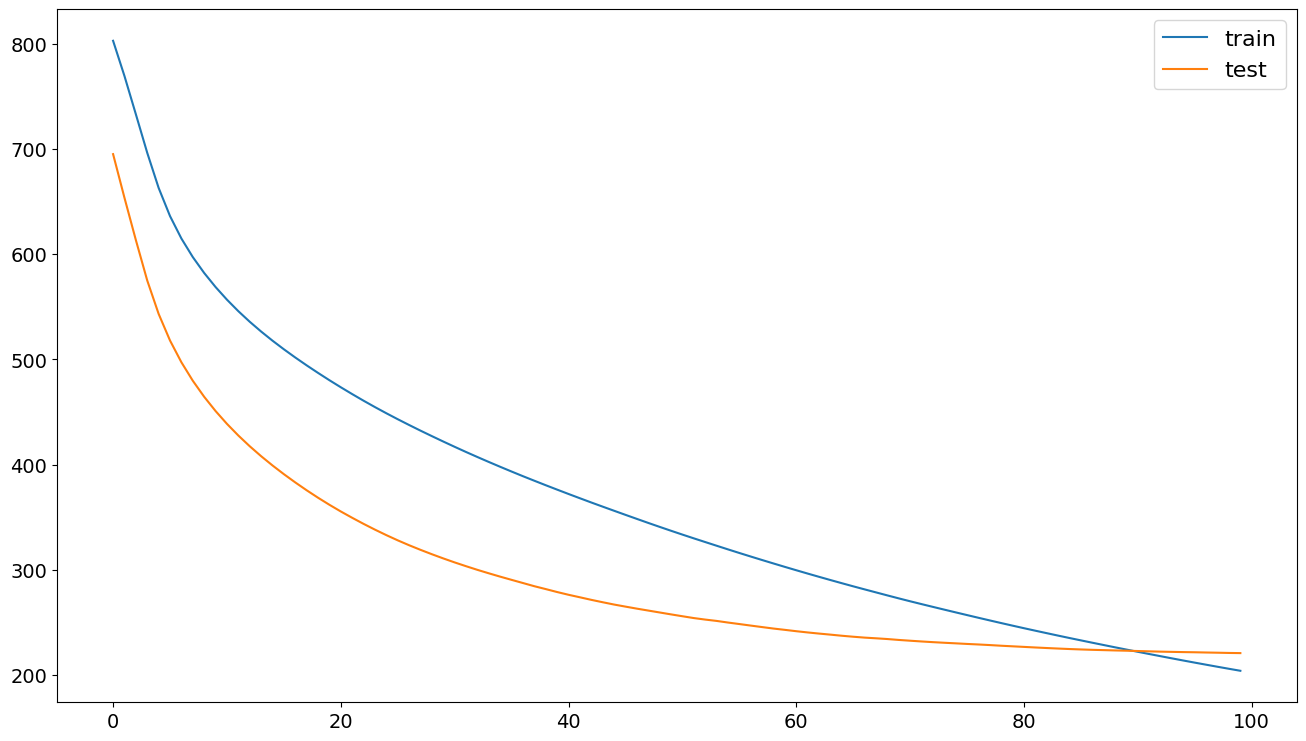

In [190]:
# plot de history sobre funcion de perdida
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
#Aumentar el tamaño de la letra
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Aumentar el tamaño de la leyeenda
leg = plt.legend(fontsize=16)

# Cambiar el eje x para que sean enteros
#plt.xticks(np.arange(1, EPOCHS, 2))
plt.show()

func_loss = history.history['val_loss']
min_epoc = func_loss.index(min(func_loss))

In [191]:
# Cargar el modelo (si ya está entrenado)
#model = joblib.load(MODEL_FILE_NAME)
#model

#### Predicción sobre el conjunto de datos de test

In [192]:
# Predición de conjunto de test
y_pred = model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [193]:
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

rmse = np.sqrt(mse)
print('RMSE:', rmse)

mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

r2 = r2_score(y_test, y_pred)
print('R2:', r2)

MSE: 220.69971193492893
RMSE: 14.855965533580404
MAE: 5.1541496151978645
R2: 0.6648367680112792


#### Métricas con variables ordinales (alto-medio-bajo)

In [194]:
# Define the classification thresholds
low_threshold = 25
medium_threshold = 50

def classify_label(value):
    if value < low_threshold:
        return 'Low'
    elif value < medium_threshold:
        return 'Medium'
    else:
        return 'High'

# To 1d array
y_pred = y_pred.flatten()
y_pred
# Classify the predictions based on the thresholds
y_true = [classify_label(value) for value in y_test]  # Replace classify_label with your own function
y_pred_clas = [classify_label(value) for value in y_pred]  # Replace classify_label with your own function

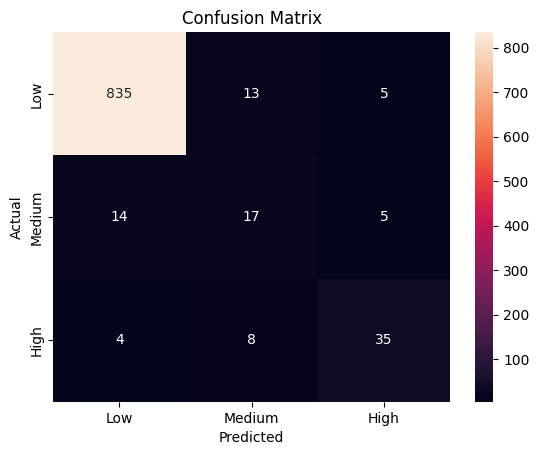

In [195]:
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
labels = ['Low', 'Medium', 'High']
cm = confusion_matrix(y_true, y_pred_clas, labels=labels)

# Display the confusion matrix with a heatmap
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [196]:
# Mostrar métricas de clasificación
from sklearn.metrics import classification_report

# Display the classification report
print(classification_report(y_true, y_pred_clas))

              precision    recall  f1-score   support

        High       0.78      0.74      0.76        47
         Low       0.98      0.98      0.98       853
      Medium       0.45      0.47      0.46        36

    accuracy                           0.95       936
   macro avg       0.73      0.73      0.73       936
weighted avg       0.95      0.95      0.95       936



# Visualización

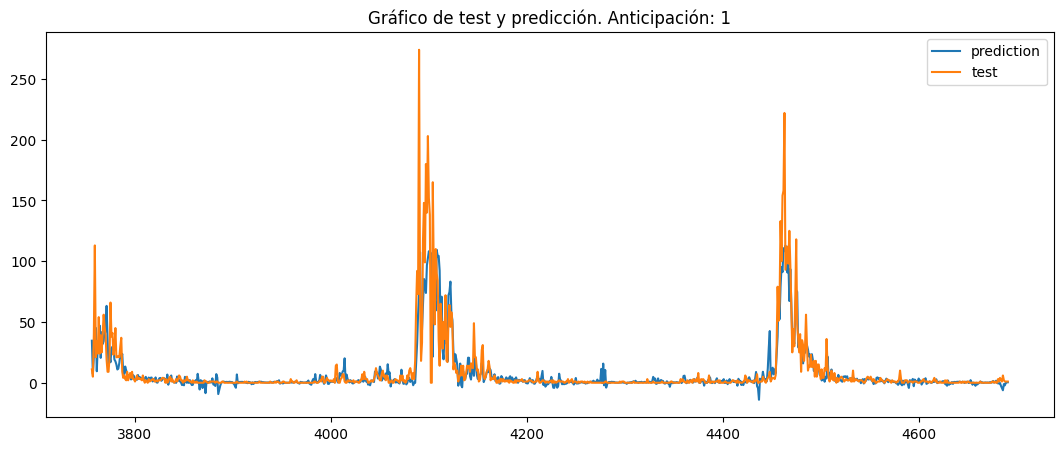

In [197]:

# pred_aux = [x[0] for x in y_pred]
# test_aux = [x[0] for x in y_test]
plt.figure(figsize=(13,5))
plt.plot(test_index,y_pred, label='prediction', color = '#1f77b4')
plt.plot(y_test, label='test', color= '#ff7f0e')
plt.legend()
plt.title(f'Gráfico de test y predicción. Anticipación: {ANTICIPACION}')

#plt.savefig(f'../imagenes/prediccion-{MODEL_FILE_NAME}-lineal.png')
plt.show()

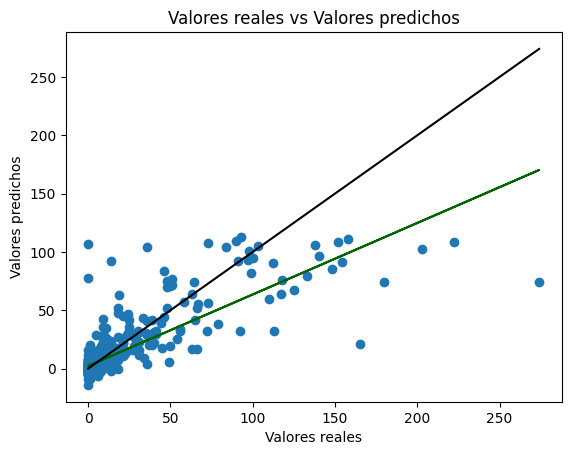

In [198]:
# Gráfico de dispersión de los valores reales frente a los predichos
plt.scatter(y_test, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Valores reales vs Valores predichos')
# Línea de tendencia
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='darkgreen')
# Línea de 45 grados
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black')
plt.show()

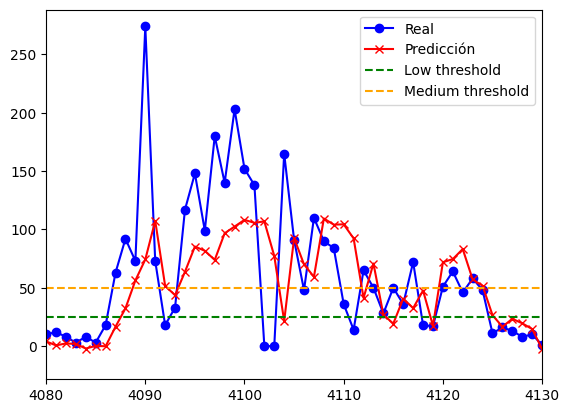

In [199]:
# Gráfico de la predicción con puntos
plt.plot(y_test.index, y_test, label='Real', color='blue', marker='o')
plt.plot(y_test.index, y_pred, label='Predicción', color='red', marker='x')
# Recortar a fragmentos cortos para poder ver lo que pasa
# plt.xlim(3175, 3220)
# plt.xlim(3520, 3560)
plt.xlim(4080, 4130)
# Dibujar líneas horizontales para los umbrales
plt.axhline(y=low_threshold, color='green', linestyle='--', label='Low threshold')
plt.axhline(y=medium_threshold, color='orange', linestyle='--', label='Medium threshold')
plt.legend()
plt.show()

## Guardado del modelo entrenado

In [200]:
# Guardado el modelo
joblib.dump(model, open(MODEL_FILE_NAME, 'wb'))